# 3. Préparation pour la Modélisation

## 3.1 Importation des bibliothèques nécessaires

In [1]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Configuration pour les visualisations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


pd.set_option('display.max_columns', None)

%matplotlib inline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 3.2 Chargement des données préparées

In [2]:
df=pd.read_pickle("C:\\Users\\hj\\OneDrive\\Bureau\TP_Class\\Data\\pickeled_data_prepared.pkl")

## 3.4 Ingénierie des caractéristiques

Basé sur l'analyse exploratoire, nous allons créer quelques caractéristiques supplémentaires qui pourraient être utiles pour la modélisation.

In [3]:
# Création du ratio prêt/revenu
df['loan_to_income'] = df['loan_amount'] / df['income']

# Création du ratio prix du bien/prêt
df['good_price_to_loan'] = df['good_price'] / df['loan_amount']

# Création du ratio dépenses/revenu
df['expenses_to_income'] = df['expenses'] / df['income']

print("Aperçu des données avec les nouvelles caractéristiques :")
df.head()

Aperçu des données avec les nouvelles caractéristiques :


,age,marital_status,expenses,income,loan_amount,good_price,credit_status,loan_to_income,good_price_to_loan,expenses_to_income
0,30,2,73,129,800,846,0,6.201550,1.057500,0.565891
1,58,3,48,131,1000,1658,0,7.633588,1.658000,0.366412
2,46,2,90,200,2000,2985,1,10.000000,1.492500,0.450000
3,24,1,63,182,900,1325,0,4.945055,1.472222,0.346154
4,26,1,46,107,310,910,0,2.897196,2.935484,0.429907


In [5]:
print("Statistiques descriptives des nouvelles caractéristiques :")
df[['loan_to_income', 'good_price_to_loan', 'expenses_to_income']].describe().T

Statistiques descriptives des nouvelles caractéristiques :


C:\Users\hj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\hj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
loan_to_income,1015.0,inf,NaN,0.960000,4.772257,7.042254,10.910903,inf
good_price_to_loan,1015.0,1.558245,0.823275,1.000000,1.128786,1.291176,1.622500,8.2
expenses_to_income,1015.0,inf,NaN,0.072289,0.317821,0.444444,0.622845,inf


##### On observe que dans certaines des nouvelles variables y'a des valeurs infinies du probablement à des individus où le `income` est nul.

In [8]:
# Vérification des valeurs infinies dans les nouvelles caractéristiques
print("Vérification des valeurs infinies dans les nouvelles caractéristiques :")
print(f"Nombre de valeurs infinies dans loan_to_income : {np.isinf(df['loan_to_income']).sum()}")
print(f"Nombre de valeurs infinies dans good_price_to_loan : {np.isinf(df['good_price_to_loan']).sum()}")
print(f"Nombre de valeurs infinies dans expenses_to_income : {np.isinf(df['expenses_to_income']).sum()}")

Vérification des valeurs infinies dans les nouvelles caractéristiques :
Nombre de valeurs infinies dans loan_to_income : 58
Nombre de valeurs infinies dans good_price_to_loan : 0
Nombre de valeurs infinies dans expenses_to_income : 58


In [ ]:
colonnes_a_verifier = ['loan_to_income', 'expenses_to_income']

print("Localisation des premières valeurs infinies :")
print("-----------------------------------------")

for col in colonnes_a_verifier:
    inf_indices = np.where(np.isinf(df[col]))[0]
    
    if len(inf_indices) > 0:
        premiere_ligne = inf_indices[0]
        print(f"Colonne '{col}':")
        print(f"  - Première valeur infinie à la ligne {premiere_ligne}")
        print(f"  - Valeur problématique : {df.at[premiere_ligne, col]}")
        print(f"  - Exemple de ligne complète :\n{df.iloc[premiere_ligne]}\n")
    else:
        print(f"Colonne '{col}': Aucune valeur infinie trouvée.\n")

Localisation des premières valeurs infinies :
-----------------------------------------
Colonne 'loan_to_income':
  - Première valeur infinie à la ligne 112
  - Valeur problématique : inf
  - Exemple de ligne complète :
age                     39.00
marital_status           1.00
expenses                35.00
income                   0.00
loan_amount           1000.00
good_price            1210.00
credit_status            1.00
loan_to_income            inf
good_price_to_loan       1.21
expenses_to_income        inf
Name: 112, dtype: float64

Colonne 'expenses_to_income':
  - Première valeur infinie à la ligne 112
  - Valeur problématique : inf
  - Exemple de ligne complète :
age                     39.00
marital_status           1.00
expenses                35.00
income                   0.00
loan_amount           1000.00
good_price            1210.00
credit_status            1.00
loan_to_income            inf
good_price_to_loan       1.21
expenses_to_income        inf
Name: 112, dtype:

##### Pour régler ce problème, on se propose de mapper ces valeurs inf, i.e on remplace les valeurs infinies par la valeur maximale non infinie

In [ ]:
for col in ['loan_to_income', 'good_price_to_loan', 'expenses_to_income']:
    if np.isinf(df[col]).sum() > 0 or np.isnan(df[col]).sum() > 0:
        # Calcul de la valeur maximale non infinie
        max_val = df[col][~np.isinf(df[col]) & ~np.isnan(df[col])].max()
        # Remplacement 
        df[col] = df[col].replace([np.inf, -np.inf], max_val)
        print(f"Valeur infinie remplacée dans {col}")

# Vérification après traitement
print("\nVérification après traitement :")
print(f"Nombre de valeurs infinies dans loan_to_income : {np.isinf(df['loan_to_income']).sum()}")
print(f"Nombre de valeurs infinies dans expenses_to_income : {np.isinf(df['expenses_to_income']).sum()}")


Valeur infinie remplacée dans loan_to_income
Valeur infinie remplacée dans expenses_to_income

Vérification après traitement :
Nombre de valeurs infinies dans loan_to_income : 0
Nombre de valeurs infinies dans expenses_to_income : 0


## 3.5 Analyse des corrélations après ingénierie des caractéristiques

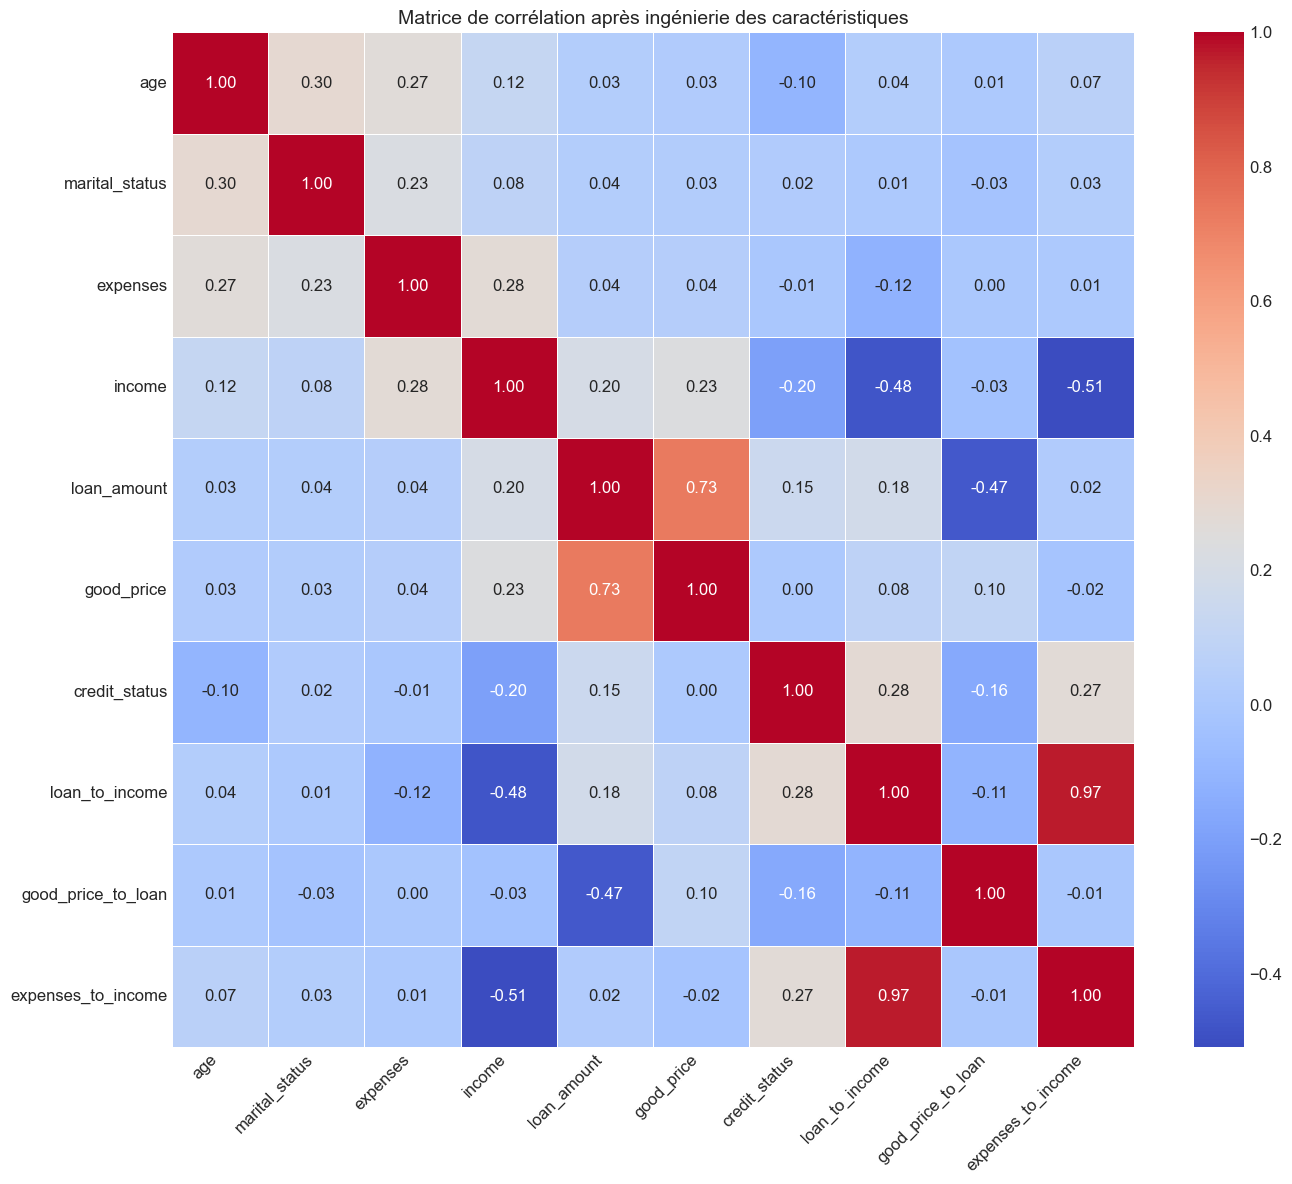

In [21]:
correlation_matrix = df.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation après ingénierie des caractéristiques', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
# Corrélations avec la variable cible
target_correlations = correlation_matrix['credit_status'].sort_values(ascending=False)
print("Corrélations avec la variable cible (credit_status) :")
target_correlations

Corrélations avec la variable cible (credit_status) :


credit_status         1.000000
loan_to_income        0.282544
expenses_to_income    0.270074
loan_amount           0.146530
marital_status        0.021502
good_price            0.004600
expenses             -0.006631
age                  -0.104055
good_price_to_loan   -0.158666
income               -0.200885
Name: credit_status, dtype: float64

### Remarque :
##### On observe une très grande corrélation entre les variables `loan_to_income` et `expense_to_income`, alors on élimine celle avec le coeff de corr le plus faible avec la cible, i.e `expense_to_income`.
##### On va aussi éliminer les variables `good_price` et `expenses` due à leur très faible corrélation avec la cible.
##### On peut penser aussi à ajouter une toute nouvelle variable `savings_rate` = (income - expenses) / income pour capturer l'épargne résiduelle, ce qui peut influencer la capacité d'un client à payer son debt.

## 3.6 Traitement Supplémentaire 

In [23]:
df_clean = df.drop(columns=['expenses_to_income', 'good_price', 'expenses'])

In [24]:
# Ajout de nouvelle variable
df_clean['savings_rate'] = (df['income'] - df['expenses']) / df['income']

#### Important : après l'ajout de cette nouvelle variable (qui dépend de `income`) il faut alors traiter le problème des valeurs inf rencontré précedement pour les variables crées à la base de `income`

In [38]:
# Vérification des valeurs infinies dans la nouvelle caractéristique
print("Vérification des valeurs infinies dans la nouvelle caractéristique :")
print(f"Nombre de valeurs infinies dans loan_to_income : {np.isinf(df_clean['loan_to_income']).sum()}")
print(f"Nombre de valeurs infinies dans expenses_to_income : {np.isinf(df_clean['savings_rate']).sum()}")

Vérification des valeurs infinies dans la nouvelle caractéristique :
Nombre de valeurs infinies dans loan_to_income : 0
Nombre de valeurs infinies dans expenses_to_income : 58


In [40]:
if np.isinf(df_clean['savings_rate']).sum() > 0 or np.isnan(df_clean['savings_rate']).sum() > 0:
        # Calcul de la valeur maximale non infinie
        max_val = df_clean['savings_rate'][~np.isinf(df_clean['savings_rate']) & ~np.isnan(df_clean['savings_rate'])].max()
        # Remplacement 
        df_clean['savings_rate'] = df_clean['savings_rate'].replace([np.inf, -np.inf], max_val)
        print(f"Valeur infinie remplacée dans savings rate")

print("\nVérification après traitement :")
print(f"Nombre de valeurs infinies dans savings_rate : {np.isinf(df_clean['savings_rate']).sum()}")


Vérification après traitement :
Nombre de valeurs infinies dans savings_rate : 0


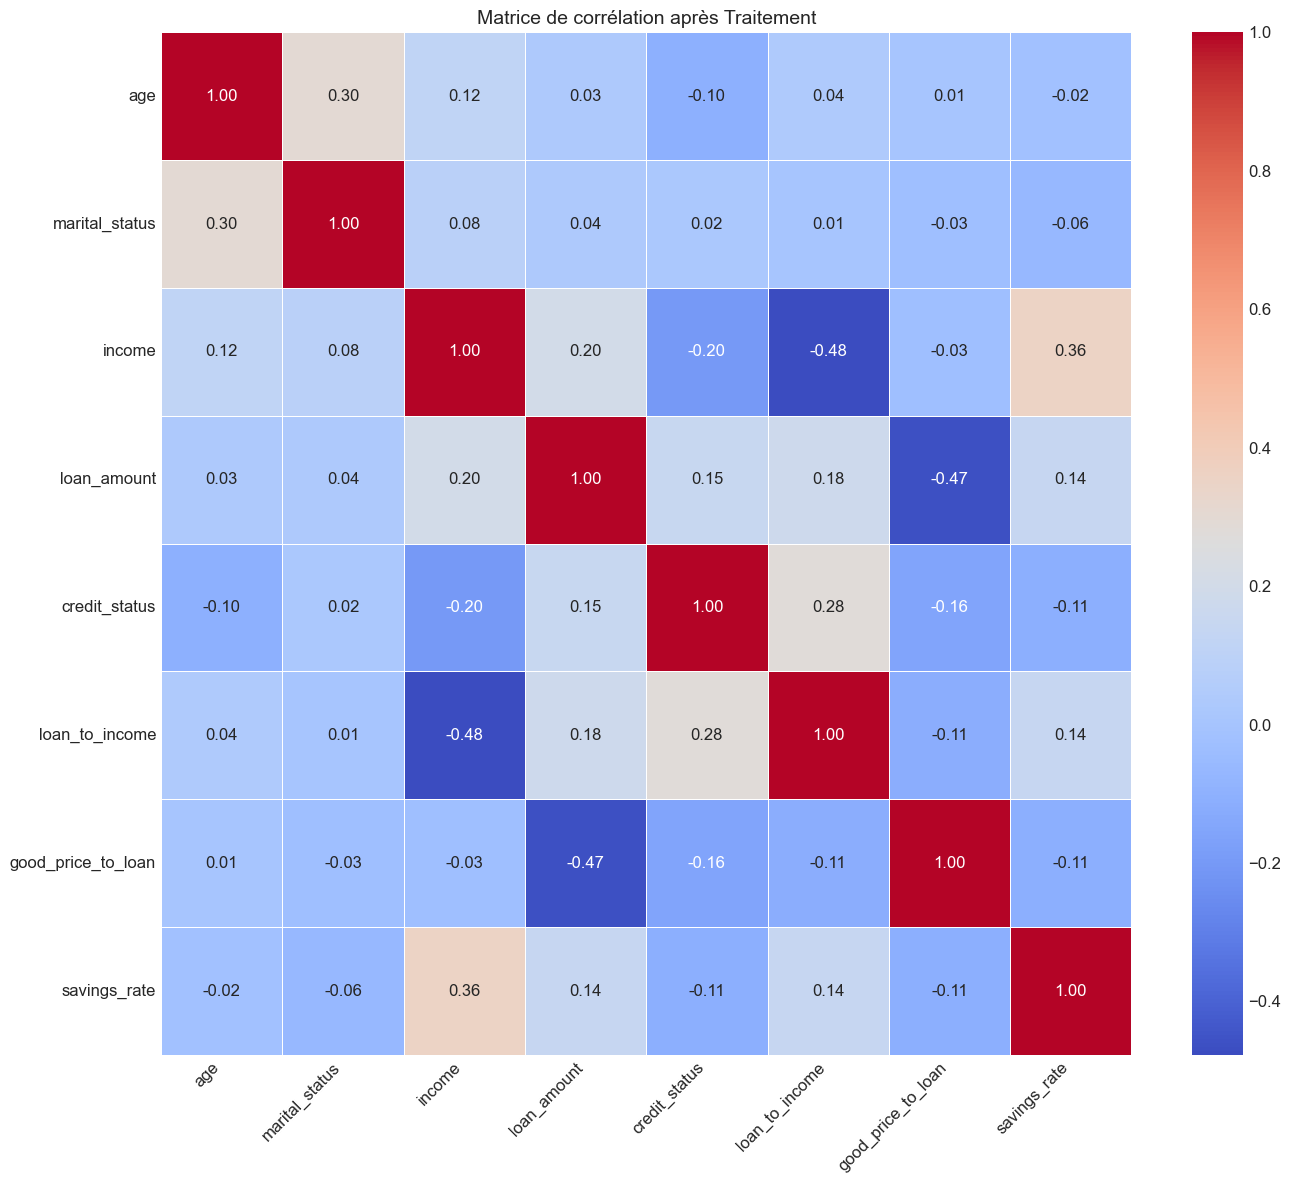

In [41]:
correlation_matrix1 = df_clean.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation après Traitement', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 3.7 Séparation des données

Nous allons maintenant séparer les données en variables explicatives (X) et variable cible (y), puis en ensembles d'entraînement et de test.

In [42]:
X = df_clean.drop('credit_status', axis=1)
y = df_clean['credit_status']

print(f"Dimensions de X : {X.shape}")
print(f"Dimensions de y : {y.shape}")

print("\nVariables explicatives :")
print(X.columns.tolist())

Dimensions de X : (1015, 7)
Dimensions de y : (1015,)

Variables explicatives :
['age', 'marital_status', 'income', 'loan_amount', 'loan_to_income', 'good_price_to_loan', 'savings_rate']


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

print(f"Dimensions de X_train : {X_train.shape}")
print(f"Dimensions de X_test : {X_test.shape}")
print(f"Dimensions de y_train : {y_train.shape}")
print(f"Dimensions de y_test : {y_test.shape}")

Dimensions de X_train : (812, 7)
Dimensions de X_test : (203, 7)
Dimensions de y_train : (812,)
Dimensions de y_test : (203,)


In [44]:
# Vérification de la distribution de la variable cible dans les ensembles d'entraînement et de test
print("Distribution de la variable cible dans l'ensemble d'entraînement :")
print(y_train.value_counts(normalize=True) * 100)

print("\nDistribution de la variable cible dans l'ensemble de test :")
print(y_test.value_counts(normalize=True) * 100)

Distribution de la variable cible dans l'ensemble d'entraînement :
credit_status
0    73.152709
1    26.847291
Name: proportion, dtype: float64

Distribution de la variable cible dans l'ensemble de test :
credit_status
0    72.906404
1    27.093596
Name: proportion, dtype: float64


##### On remarque alors que la distribution de la cible est quasi la meme dans les deux datasets et pour les deux plantes

## 3.8 Standardisation des variables numériques

Nous allons standardiser les variables numériques pour qu'elles aient une moyenne de 0 et un écart-type de 1. Cela est important pour de nombreux algorithmes d'apprentissage automatique, en particulier ceux qui sont basés sur la distance comme KNN.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train) # On entraine le scaler juste sur la base d'entrainement pourque le test soit plus fidèle à la réalité

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [47]:
# Vérification des statistiques des données standardisées
print("Statistiques des données standardisées (ensemble d'entraînement) :")
X_train_scaled_df.describe().T[['mean', 'std', 'min', 'max']]

Statistiques des données standardisées (ensemble d'entraînement) :


,mean,std,min,max
age,2.187632e-17,1.000616,-1.732353,2.756534
marital_status,-1.356332e-16,1.000616,-1.525958,5.171761
income,-1.071939e-16,1.000616,-1.495022,7.988481
loan_amount,-1.257888e-16,1.000616,-2.058650,6.109191
loan_to_income,0.000000e+00,1.000616,-0.580218,3.925504
good_price_to_loan,1.378208e-16,1.000616,-0.667222,7.009676
savings_rate,-4.375263e-17,1.000616,-12.689792,1.240778


## 3.9 Sauvegarde des données préparées pour la modélisation

Nous allons sauvegarder les ensembles d'entraînement et de test, ainsi que le scaler, pour les utiliser dans les notebooks de modélisation.

In [48]:
model_data_dir = "C:\\Users\\hj\\OneDrive\\Bureau\TP_Class\\Data"

joblib.dump(X_train, os.path.join(model_data_dir, "X_train.pkl"))
joblib.dump(X_test, os.path.join(model_data_dir, "X_test.pkl"))
joblib.dump(y_train, os.path.join(model_data_dir, "y_train.pkl"))
joblib.dump(y_test, os.path.join(model_data_dir, "y_test.pkl"))

joblib.dump(X_train_scaled, os.path.join(model_data_dir, "X_train_scaled.pkl"))
joblib.dump(X_test_scaled, os.path.join(model_data_dir, "X_test_scaled.pkl"))

joblib.dump(scaler, os.path.join(model_data_dir, "scaler.pkl"))

# Sauvegarde des noms des variables explicatives
with open(os.path.join(model_data_dir, "feature_names.txt"), "w") as f:
    f.write("\n".join(X.columns.tolist()))

print(f"Données préparées pour la modélisation sauvegardées avec succès dans le dossier : {model_data_dir}")

Données préparées pour la modélisation sauvegardées avec succès dans le dossier : C:\Users\hj\OneDrive\Bureau\TP_Class\Data


## 3.10 Visualisation de la distribution des données standardisées

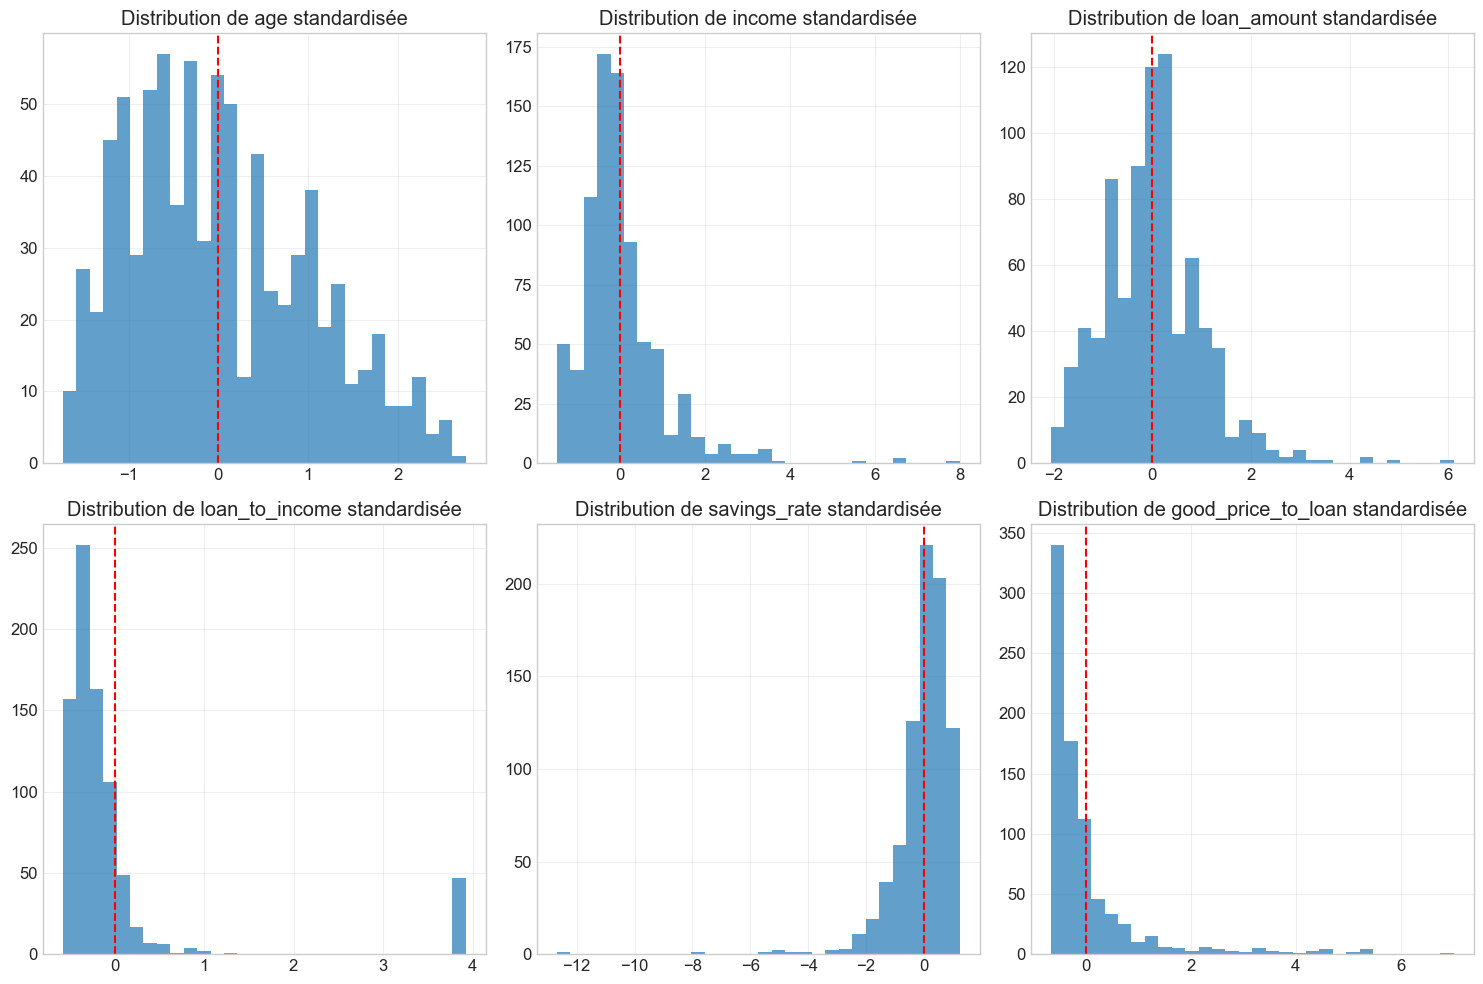

In [49]:
plt.figure(figsize=(15, 10))
selected_features = ['age', 'income', 'loan_amount', 'loan_to_income', 'savings_rate', 'good_price_to_loan']
selected_indices = [X_train.columns.get_loc(feature) for feature in selected_features]

for i, idx in enumerate(selected_indices):
    plt.subplot(2, 3, i+1)
    plt.hist(X_train_scaled[:, idx], bins=30, alpha=0.7)
    plt.title(f'Distribution de {X_train.columns[idx]} standardisée')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3.11 Résumé de la préparation pour la modélisation

Dans ce notebook, nous avons effectué les opérations suivantes :

1. **Chargement des données préparées** : Nous avons chargé les données préparées dans le notebook précédent.

2. **Ingénierie des caractéristiques** : Nous avons créé de nouvelles caractéristiques qui pourraient être utiles pour la modélisation :
   - `loan_to_income` : Ratio entre le montant du prêt et le revenu
   - `good_price_to_loan` : Ratio entre le prix du bien et le montant du prêt
   - `expenses_to_income` : Ratio entre les dépenses et le revenu

3. **Séparation des données** : Nous avons séparé les données en variables explicatives (X) et variable cible (y), puis en ensembles d'entraînement (80%) et de test (20%).

4. **Standardisation des variables numériques** : Nous avons standardisé les variables numériques pour qu'elles aient une moyenne de 0 et un écart-type de 1.

5. **Sauvegarde des données préparées** : Nous avons sauvegardé les ensembles d'entraînement et de test, ainsi que le scaler, pour les utiliser dans les notebooks de modélisation.

6. **Analyse des corrélations** : Nous avons analysé les corrélations entre les variables après l'ingénierie des caractéristiques pour identifier les variables les plus importantes pour la modélisation.

### Observations importantes :

1. **Variables les plus corrélées avec la variable cible** :
   - `loan_to_income` : Cette nouvelle caractéristique est fortement corrélée avec le statut de crédit, ce qui confirme l'importance du ratio entre le montant du prêt et le revenu.
   - `loan_amount` : Le montant du prêt est positivement corrélé avec le statut de non-solvabilité.
   - `income` : Le revenu est négativement corrélé avec le statut de non-solvabilité.

2. **Distribution équilibrée** : Nous avons utilisé la stratification lors de la séparation des données pour maintenir la même distribution de la variable cible dans les ensembles d'entraînement et de test.

3. **Standardisation réussie** : Les variables standardisées ont bien une moyenne proche de 0 et un écart-type proche de 1, ce qui est important pour les algorithmes sensibles à l'échelle des variables.